In [1]:
from difference_models import BinaryDifferenceClassifier, MulticlassDifferenceClassifier
import util
from shap.maskers import Independent
from sklearn.utils import resample, shuffle
import shap
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
%matplotlib inline
shap.initjs()

In [2]:
with open('classifiers.pickle', 'rb') as f:
    clf_a, clf_b = pickle.load(f)
with open('dataset.pickle', 'rb') as f:
    X, y, feature_names, n_features, n_samples = pickle.load(f)

In [3]:
try:
    with open('shapvalues.multiclassdiff.proba.pickle', 'rb') as f:
        shap_values = pickle.load(f)
        print('Loaded cached shap values')
except FileNotFoundError:
    print('No cached shap values found')

Loaded cached shap values


## Generate Explanations

In [4]:
diff_clf = MulticlassDifferenceClassifier(clf_a, clf_b)
diff_clf.fit(X, y)
proba_equal = diff_clf.predict_proba(X)

Now we generate SHAP values for the difference classifier:

In [5]:
%%time
background_data = X
masker = Independent(data=background_data, max_samples=100)
explainer = shap.Explainer(diff_clf.predict_proba, masker, feature_names=feature_names)
shap_values = explainer(X)
with open(f'shapvalues.multiclassdiff.proba.pickle', 'wb') as f:
    pickle.dump(shap_values, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 5.51 s, sys: 120 ms, total: 5.63 s
Wall time: 6.16 s


## Analyze

Preparations:

In [5]:
indices = np.indices(y.shape).ravel()
binary_diff_clf = BinaryDifferenceClassifier(clf_a, clf_b)
binary_diff_clf.fit(X, y)
is_pred_equal = binary_diff_clf.predict(X)
is_pred_diff = ~is_pred_equal

In [6]:
shap_values_equality = util.reduce_multiclass_proba_diff_shap_values(shap_values)
overall_importance = shap_values_equality.abs.mean(axis=0)
feature_order = np.flip(overall_importance.values.argsort())

### Feature Importance

#### Bar Plots

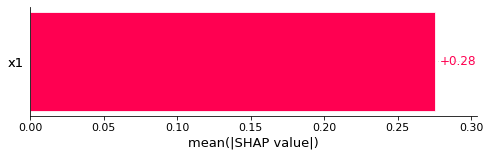

In [8]:
shap.plots.bar(overall_importance, max_display=n_features)

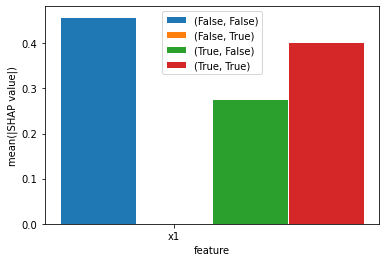

In [9]:
bar_width = 0.25
importances = shap_values.abs.mean(0).values.T
rects = [i * bar_width + np.arange(importances.shape[1]) for i in range(importances.shape[0])]
for class_idx, rect, importance in zip(diff_clf.classes_, rects, importances):
    plt.bar(rect, importance, width=bar_width, edgecolor='white', label=str(diff_clf.class_tuples[class_idx]))
plt.xlabel('feature')
plt.ylabel('mean(|SHAP value|)')
plt.xticks([r + bar_width for r in range(importances.shape[1])], feature_names)
plt.legend()
plt.show()

#### SHAP Value Distribution

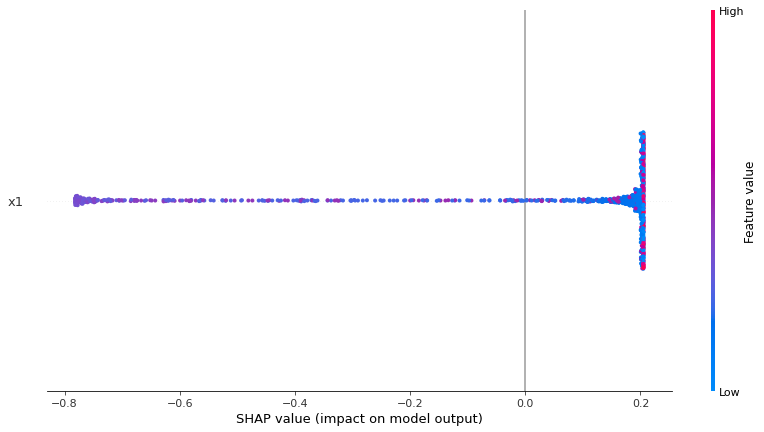

In [10]:
shap.plots.beeswarm(shap_values_equality, order=feature_order, plot_size=(14, 7))

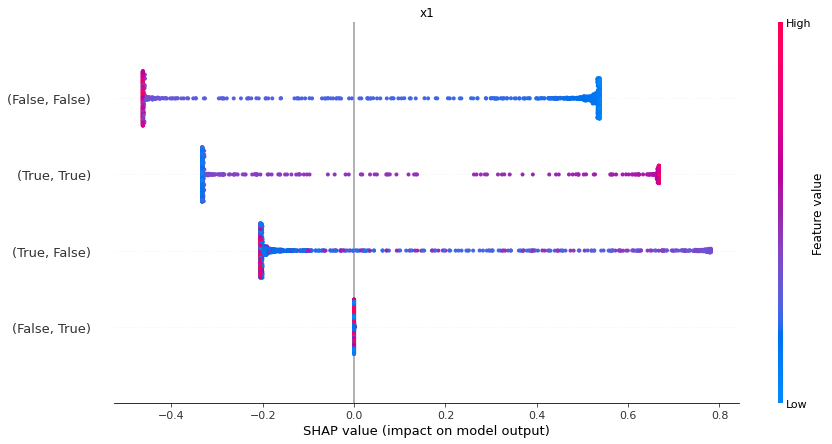

In [11]:
for idx_feature, feature in enumerate(feature_names):
    values = shap_values.values[:, idx_feature, :]
    data = np.reshape(np.repeat(shap_values.data[:, idx_feature], len(diff_clf.classes_)), (X.shape[0], len(diff_clf.classes_)))
    base_values = shap_values.base_values[:, idx_feature]
    class_names = [str(class_tuple) for class_tuple in diff_clf.class_tuples]
    shap_values_ = shap.Explanation(values, base_values, data, feature_names=class_names)
    shap.plots.beeswarm(shap_values_, plot_size=(14, 7), show=False)
    plt.title(feature)
    plt.show()

### Feature Effects

#### Partial Dependence Plots

Plot in blue are the instances where A and B predict the same label, plot over in red are instances where they differ.

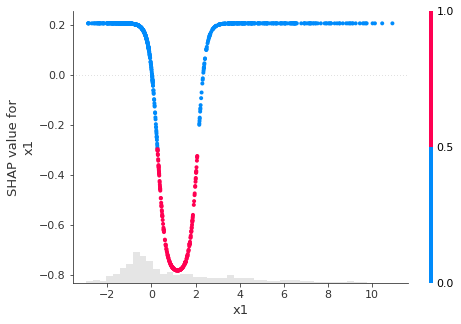

In [12]:
for feature in feature_names:
    shap.plots.scatter(shap_values_equality[:, feature], color=is_pred_diff)

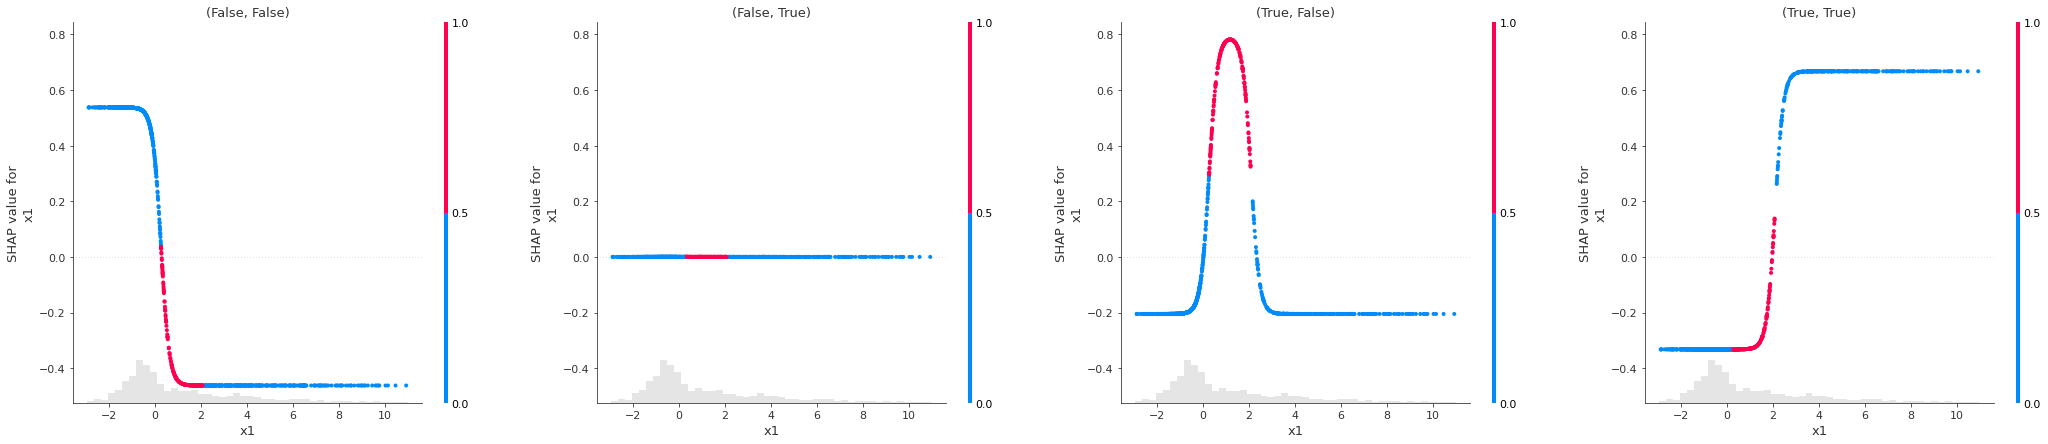

In [13]:
n_columns = len(diff_clf.classes_)
n_rows = n_features
fig = plt.figure(figsize=(9 * n_columns, 7 * n_rows))
plot_idx = 1
for feature in feature_names:
    ax_ref = None
    for class_idx, class_tuple in enumerate(diff_clf.class_tuples):
        ax = fig.add_subplot(n_rows, n_columns, plot_idx, sharey=ax_ref)
        if not ax_ref:
            ax_ref = ax
        shap.plots.scatter(shap_values[:, feature, class_idx], title=str(class_tuple), ax=ax, color=is_pred_diff, show=False)
        plot_idx += 1
plt.show()

### Cluster

#### Force plots

In [14]:
shap.plots.force(
    base_value=shap_values_equality.base_values[0],
    shap_values=shap_values_equality.values,
    features=shap_values_equality.data,
    feature_names=feature_names)

In [15]:
for class_idx, class_tuple in enumerate(diff_clf.class_tuples):
    shap_values_ = shap_values[:, :, class_idx]
    plot = shap.plots.force(
        base_value=shap_values_.base_values[0],
        shap_values=shap_values_.values,
        features=shap_values_.data,
        feature_names=feature_names,
        out_names=str(class_tuple))
    display(plot)

#### Heatmaps

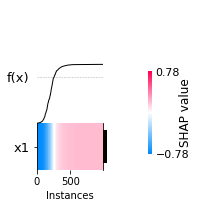

In [16]:
shap.plots.heatmap(shap_values_equality, max_display=n_features, feature_order=feature_order)

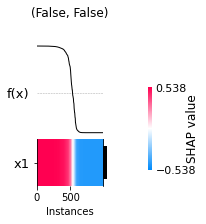

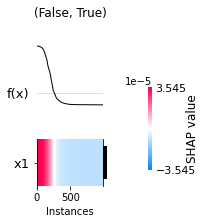

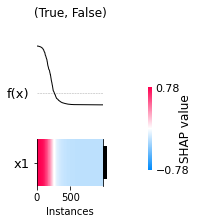

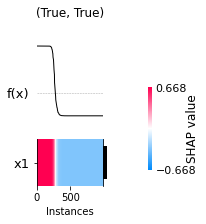

In [17]:
for class_idx, class_tuple in enumerate(diff_clf.class_tuples):
    shap_values_ = shap_values[:, :, class_idx]
    shap.plots.heatmap(shap_values_, max_display=n_features, show=False)
    plt.title(str(class_tuple))
    plt.show()

#### Decision plots

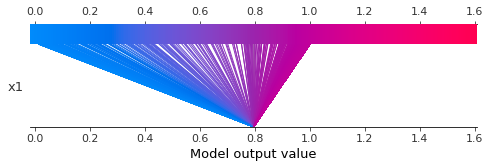

In [7]:
shap.plots.decision(shap_values_equality.base_values[0], shap_values_equality.values, feature_names=feature_names)

We can also visualize the individual shap values per difference class for a single instance, and we select the instance with the highest shap value

In [8]:
def class_labels(row_index):
    return [f'{diff_clf.class_tuples[i]} ({proba_equal[row_index, i].round(2):.2f})' for i in range(len(diff_clf.classes_))]

In [9]:
def plot_multioutput_decision(row_index):
    shap.multioutput_decision_plot(shap_values.base_values[0, :].tolist(),
                                   [a.T for a in list(shap_values.values.T)],
                                   row_index=row_index,
                                   feature_names=feature_names, 
                                   highlight=[np.argmax(is_pred_equal[row_index])],
                                   legend_labels=class_labels(row_index),
                                   legend_location='lower right')

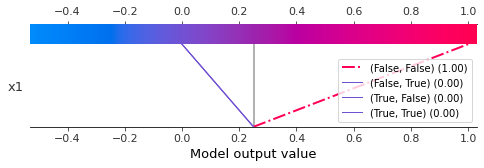

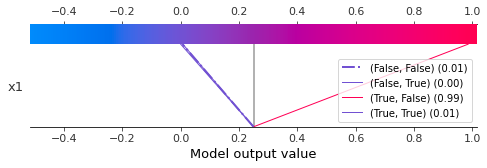

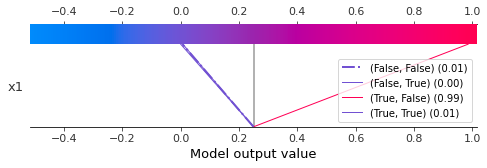

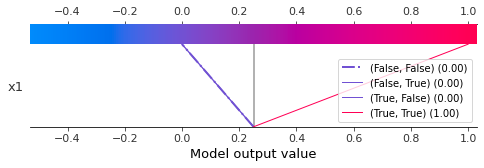

In [10]:
for class_idx in diff_clf.classes_:
    idx_max = np.argmax(shap_values.values[:, 0, class_idx])
    plot_multioutput_decision(idx_max)